In [1]:
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import bisect

In [2]:
""" Pre-Processing """
class preprocesser:
    def __init__(self, df, config):
        self.df = df
        self.scaleDown = config['ScaleDown']
        self.filterMap = config['FilterMap']
        self.vesselType = config['VesselType']
    
    def preprocess(self):
        self.df = self.df[(self.df['LAT'] > -80) & (self.df['LAT'] < 84) & (self.df['LON'] > -180) & (self.df['LON'] < 180)]
        self.convertCoord()
        self.scaleDownData()
        self.filterMapToScale()

        if self.vesselType != None:
            self.df = self.df[df.VesselType == vesselType]
        if len(self.df) >= 1:
            self.processTime()
        else:
            self.df['time'] = []
        self.df = self.df.reset_index()
        self.df = self.df[['MMSI', 'x', 'y', 'time', 'VesselType', 'Heading']]
        def process_heading(x):
            if x > 360 or x < 0:
                return None
            return x
        self.df['Heading'] = self.df['Heading'].apply(lambda x: process_heading(x))
    
    def convertCoord(self):
        latitudes = np.array(self.df['LAT'])
        longitudes = np.array(self.df['LON'])
        self.df['x'], self.df['y'], _, _ = utm.from_latlon(latitudes, longitudes)
    
    def scaleDownData(self):
        self.df['x'] = self.df['x'] / self.scaleDown
        self.df['y'] = self.df['y'] / self.scaleDown
    
    def filterMapToScale(self):
        right_x, left_x, top_y, bot_y = self.filterMap
        self.df = self.df[(self.df.x<right_x) & (self.df.x>left_x) & (self.df.y<top_y) & (self.df.y>bot_y)]
    
    def processTime(self):
        self.df['datetime'] = pd.to_datetime(self.df['BaseDateTime'])
        self.df.sort_values(by=['datetime'], inplace=True, ascending=True)
        self.df = self.df.reset_index()
        start_datetime = self.df['datetime'].iloc[0].floor('d')
        self.df['time'] = self.df['datetime'].apply(lambda x: (x-start_datetime)).dt.total_seconds()

        
""" LATTICE-BASED DBSCAN """
class DBSCAN:
    def __init__(self, df, config):
        self.df = df
        self.numRow = config['NumRow']
        self.numCol = config['NumCol']
        self.min_x = config['Min_x']
        self.min_y = config['Min_y']
        self.increment = config['Increment']
        self.vesselType = config['VesselType']
        self.minSC = config['MinSC']
        self.minNeigb = config['MinNeigb']
        
        self.lattice = self.initialize_lattice()
    
    def get_index(self, pos_x, pos_y):
        index_x = math.ceil((pos_x - self.min_x) / self.increment) - 1
        index_y = self.numRow - math.ceil((pos_y - self.min_y) / self.increment)
        if pos_x == self.min_x:
            index_x = 0
        if pos_y == self.min_y:
            index_y = self.numRow-1
        return index_x, index_y
    
    def initialize_lattice(self):
        lattice = [[None] * self.numCol for _ in range(self.numRow)]
        for i in range(self.numRow):
            for j in range(self.numCol):
                lattice[self.numRow-1-i][j] = {'x': self.min_x + j*self.increment,
                                               'y': self.min_y + i*self.increment,
                                               'code': None,
                                               'sampleCount': 0,
                                               'type/vslid': self.vesselType,
                                               'label': None,
                                               'clusterId': None}
        for idx, row in self.df.iterrows():
            index_x, index_y = self.get_index(row['x'], row['y'])
            lattice[index_y][index_x]['sampleCount'] += 1
        return lattice
    
    def get_neighbors(self, col, row):
        positions = [(col-1, row), (col-1, row-1), 
                     (col, row-1), (col+1, row-1), 
                     (col+1, row), (col+1, row+1), 
                     (col, row+1), (col-1, row+1)]
        ret = []
        numNeigb = 0
        for pos in positions:
            if (pos[0] < 0 or pos[0] >= len(self.lattice[0]) or
                    pos[1] < 0 or pos[1] >= len(self.lattice)):
                continue
            if self.lattice[pos[1]][pos[0]] == 'noise':
                continue
            else:
                if self.lattice[pos[1]][pos[0]]['sampleCount'] <= self.minSC:
                    self.lattice[pos[1]][pos[0]]['label'] = 'noise'
                else:
                    if not self.lattice[pos[1]][pos[0]]['label']:
                        ret.append(pos)
                    numNeigb += 1
        return ret, numNeigb
    
    def process_node(self, node, curr_cluster):
        q = deque()
        if self.lattice[node[1]][node[0]]['sampleCount'] <= self.minSC:
            self.lattice[node[1]][node[0]]['label'] = 'noise'
            return False
        neighbors, numNeigb = self.get_neighbors(node[0], node[1])
        
        if numNeigb >= self.minNeigb:
            self.lattice[node[1]][node[0]]['clusterId'] = curr_cluster
            self.lattice[node[1]][node[0]]['label'] = 'processed'
            for neighbor in neighbors:
                q.append(neighbor)
                self.lattice[neighbor[1]][neighbor[0]]['label'] = 'unprocessed'
        else:
            return False
        
        while q:
            cur = q.popleft()
            self.lattice[cur[1]][cur[0]]['clusterId'] = curr_cluster
            self.lattice[cur[1]][cur[0]]['label'] = 'processed'
            neighbors, numNeigb = self.get_neighbors(cur[0], cur[1])
            
            if numNeigb >= self.minNeigb:
                for neighbor in neighbors:
                    q.append(neighbor)
                    self.lattice[neighbor[1]][neighbor[0]]['label'] = 'unprocessed'
        return True
    
    def scan(self):
        curr_cluster = 1
        for i in range(self.numRow):
            for j in range(self.numCol):
                if self.lattice[i][j]['label'] == 'noise' or self.lattice[i][j]['label'] == 'processed':
                    continue
                else:
                    node = (j,i)
                    foundCluster = self.process_node(node, curr_cluster)
                    if foundCluster:
                        curr_cluster += 1
                        
                        
""" KDE BASED VESSEL MOTION BEHAVIOR """
from sklearn.neighbors import KernelDensity
# from sklearn.model_selection import GridSearchCV

class kde_motion:
    def __init__(self, df, config):
        self.df = df
        self.time_windows = config['TimeWindows']
        self.store_param = config['StoreParam']
        self.vessels = self.get_vessels()
        self.vessels_pdfs = {}
        
    def get_vessels(self):
        return self.df['MMSI'].unique()
    
    def get_vessel_df(self, selected_vessel):
        new_df = self.df[self.df.MMSI == selected_vessel]
        new_df = new_df.reset_index()
        return new_df
    
    def get_traveling_dist(self, vessel_x, vessel_y, vessel_time, time_window):
        num_segments = (int(vessel_time.max()) - int(vessel_time.min())) // time_window
        traveling_dist = [None] * num_segments
        traveling_variation = [None] * (num_segments - 1)
        
        j = 1
        prev_x, prev_y = vessel_x[0], vessel_y[0]
        total_traveling_dist = 0
        for i in range(num_segments):
            time = (i+1) * time_window + vessel_time[0]
            while time > vessel_time[j]:
                j += 1
            ratio = (time - vessel_time[j-1]) / (vessel_time[j] - vessel_time[j-1])
            pos_x = (vessel_x[j] - vessel_x[j-1]) * ratio + prev_x
            pos_y = (vessel_y[j] - vessel_y[j-1]) * ratio + prev_y
            distance = ((pos_x - prev_x) ** 2 + (pos_y - prev_y) ** 2) ** 0.5
            total_traveling_dist += distance
            traveling_dist[i] = total_traveling_dist
            prev_x, prev_y = pos_x, pos_y
            if i>0:
                traveling_variation[i-1] = traveling_dist[i] - traveling_dist[i-1]

        return np.array(traveling_dist), np.array(traveling_variation)
    
    def conduct_kde_single(self, time_window, selected_vessel):
        new_df = self.get_vessel_df(selected_vessel)
        traveling_dist, traveling_variation = self.get_traveling_dist(new_df['x'], new_df['y'], new_df['time'], time_window)
        
#         grid = GridSearchCV(KernelDensity(kernel='gaussian'),
#                            {'bandwidth': np.linspace(0.1, 1.0, 30)},
#                            cv=20)
#         grid.fit(traveling_variation[:, None])
#         x_grid = np.linspace(self.store_param[0], self.store_param[1], self.store_param[2])
#         kde = grid.best_estimator_
#         pdf = np.exp(kde.score_samples(x_grid[:, None]))

        kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(traveling_variation[:, None])
        x_grid = np.linspace(self.store_param[0], self.store_param[1], self.store_param[2])
        pdf = np.exp(kde.score_samples(x_grid[:, None]))
        
        return pdf
    
    def get_pdfs(self):
        for vessel in self.vessels:  # HERE WE ONLY USE 5 VESSELS TO CALCULATE
            vessel_pdf_list = {}
            for time_window in self.time_windows:
                vessel_pdf_list[time_window] = (self.conduct_kde_single(time_window, vessel))
            self.vessels_pdfs[str(vessel)] = vessel_pdf_list
        return self.vessels_pdfs
    
    def combine_pdfs(self):
        combined_pdfs = {}
        for i in range(len(self.time_windows)):
            comb_pdf = np.zeros(self.store_param[2])
            for key in self.vessels_pdfs.keys():
                comb_pdf += self.vessels_pdfs[key][self.time_windows[i]]
            comb_pdf /= len(self.vessels_pdfs)
            combined_pdfs[self.time_windows[i]] = comb_pdf
        return combined_pdfs
    
""" MOTION PREDICTION """
class motion_prediction:
    def __init__(self, lattice, pdf, present_df, config):
        self.lattice = lattice
        self.pdf = pdf
        self.present_df = present_df
        self.ship_mmsi = present_df["MMSI"].iloc[0]
        
        self.store_param = config['StoreParam']
        self.time_windows = config['TimeWindows']
        self.numCol = config['NumCol']
        self.numRow = config['NumRow']
        self.min_x = config['Min_x']
        self.min_y = config['Min_y']
        self.increment = config['Increment']
        self.threshold = config['Threshold']
        
        self.initial_PTP = None
        self.initial_ELR = None
        self.initial_index_x = None
        self.initial_index_y = None
        self.cur_waterway = None
        self.deviation_ratio = 0
        self.cur_dir = None
        self.cur_heading = None
        self.results = {}
    
    def initialize_variables(self):
        cur_time = self.present_df['time'].iloc[-1]
        
        self.initial_index_x, self.initial_index_y = self.get_index(self.present_df['x'].iloc[-1], self.present_df['y'].iloc[-1])
        self.cur_waterway = self.lattice[self.initial_index_y][self.initial_index_x]['clusterId']
        
        self.cur_heading = self.present_df['Heading'].iloc[-1]
        self.cur_dir = self.encode_direction(self.present_df['Heading'].iloc[-1])
        if self.cur_dir == None:
            _, self.cur_heading = self.compute_traveling_dist(self.time_windows[-1])
            self.cur_dir = self.encode_direction(self.cur_heading)
            
        self.initial_PTP, self.initial_ELR = self.find_PTP_ELR(self.initial_index_x, self.initial_index_y, self.cur_dir, self.cur_waterway)
        self.deviation_ratio = self.get_deviation_ratio(self.initial_PTP, self.initial_ELR, (self.initial_index_x, self.initial_index_y))
        return True
        
    
    def compute_traveling_dist(self, time_window):
        cur_time = self.present_df['time'].iloc[-1]
        cur_x = self.present_df['x'].iloc[-1]
        cur_y = self.present_df['y'].iloc[-1]
        vessel_time = self.present_df['time']
        vessel_x = self.present_df['x']
        vessel_y = self.present_df['y']
        
        prev_time = cur_time - time_window
        index = bisect.bisect(vessel_time, prev_time, lo=max(0, len(vessel_time)-time_window), hi=len(vessel_time))
        
        ratio = (prev_time - vessel_time[index-1]) / (vessel_time[index] - vessel_time[index-1])
        prev_x = (vessel_x[index] - vessel_x[index-1]) * ratio + vessel_x[index-1]
        prev_y = (vessel_y[index] - vessel_y[index-1]) * ratio + vessel_y[index-1]
        dist = ((cur_x - prev_x) ** 2 + (cur_y - prev_y) ** 2) ** 0.5
        
        heading = math.degrees(math.atan2(cur_y-prev_y, cur_x-prev_x))
        heading =- 90
        if heading < 0:
            heading *= -1
        elif heading > 0:
            heading = 360 - heading
        
        return dist, heading

    
    def compute_sail_window(self, traveling_dist):
        if not self.threshold:
            return (traveling_dist - self.increment * 0.5, traveling_dist + self.increment * 1000), None
        prob = 0
        center = self.store_param[2]//2
        pdf_increment = (self.store_param[1] - self.store_param[0]) / (self.store_param[2] - 1)
        i = 0
        prob += self.pdf[center] * pdf_increment
        while prob < self.threshold:
            i += 1
            prob += self.pdf[center+i] * pdf_increment
            prob += self.pdf[center-i] * pdf_increment
        sail_window = (traveling_dist + min(-self.increment*0.5, 0-i*pdf_increment),
                       traveling_dist + max(self.increment*1000, 0+i*pdf_increment))
        
        return sail_window, prob
    
    def find_PTP_ELR(self, index_x, index_y, cur_dir, cur_waterway):
        ELR = deque()
        ELR.append((index_x, index_y))
        if cur_dir in {0,2}:
            for i in range(index_x + 1, len(self.lattice[0])):
                if self.lattice[index_y][i]['clusterId'] == cur_waterway:
                    ELR.append((i, index_y))
                else:
                    break
            for j in reversed(range(index_x)):
                if self.lattice[index_y][j]['clusterId'] == cur_waterway:
                    ELR.appendleft((j, index_y))
                else:
                    break
        else:
            for i in range(index_y + 1, len(self.lattice)):
                if self.lattice[i][index_x]['clusterId'] == cur_waterway:
                    ELR.append((index_x, i))
                else:
                    break
            for j in reversed(range(index_y)):
                if self.lattice[j][index_x]['clusterId'] == cur_waterway:
                    ELR.appendleft((index_x, j))
                else:
                    break
        PTP = ELR[len(ELR)//2]
        return PTP, ELR
    
    def get_neighbor_index(self, index_x, index_y, cur_dir):
        if cur_dir == 0:
            return (index_x, index_y - 1)
        elif cur_dir == 1:
            return (index_x + 1, index_y)
        elif cur_dir == 2:
            return (index_x, index_y + 1)
        else:
            return (index_x - 1, index_y)
        
    def get_index(self, pos_x, pos_y):
        index_x = math.ceil((pos_x - self.min_x) / self.increment) - 1
        index_y = self.numRow - math.ceil((pos_y - self.min_y) / self.increment)
        if pos_x == self.min_x:
            index_x = 0
        if pos_y == self.min_y:
            index_y = self.numRow - 1
        return index_x, index_y
    
    def check_valid(self, index_x, index_y):
        if 0 <= index_x <= len(self.lattice[0]) - 1 and 0 <= index_y <= len(self.lattice) - 1:
            return True
        else:
            return False
        
    def forecast_trajectory(self):
        traveling_distances = {}
        sail_windows = [(0,0)] * (self.time_windows[-1]+1)
        temp_results = {}
        start_recursion = 1
        
        cur_x, cur_y = self.present_df['x'].iloc[-1], self.present_df['y'].iloc[-1]
        self.initialize_variables()
        
        if self.cur_waterway == None:
            return None

        if self.cur_dir == 0:
            dist_threshold = self.lattice[self.initial_index_y][self.initial_index_x]['y'] + self.increment - cur_y
        elif self.cur_dir == 1:
            dist_threshold = self.lattice[self.initial_index_y][self.initial_index_x]['x'] + self.increment - cur_x
        elif self.cur_dir == 2:
            dist_threshold = cur_y - self.lattice[self.initial_index_y][self.initial_index_x]['y']
        else:
            dist_threshold = cur_x - self.lattice[self.initial_index_y][self.initial_index_x]['x']
        
        for i in range(1, self.time_windows[-1] +1):
            # Step 1: Compute all traveling distances
            traveling_dist, direction = self.compute_traveling_dist(time_window=i)
            traveling_distances[i] = traveling_dist
            
            if traveling_dist < dist_threshold:
                start_recursion = i+1
                continue

            # Step 2: Compute all sail windows
            if self.pdf:
                sail_window, prob = self.compute_sail_window(traveling_dist=traveling_dist)
            else:
                sail_window, prob = self.compute_sail_window(traveling_dist=traveling_dist)
            sail_windows[i] = sail_window
        
        for j in range(1, start_recursion):
            temp_results[j] = {'PTP': self.initial_PTP, 'ELR': self.initial_ELR, 'deviated_pos': (self.initial_index_x, self.initial_index_y)}

        results = self.forecast_trajectory_dfs(PTP=self.initial_PTP, 
                                               ELR=self.initial_ELR, 
                                               deviated_pos=(self.initial_index_x, self.initial_index_y),
                                               sail_windows=sail_windows, 
                                               accumulated_dist=0,
                                               time=start_recursion,
                                               res=temp_results,
                                               deviation_ratio=self.deviation_ratio,
                                              )
        return results
        
    def forecast_trajectory_dfs(self, PTP, ELR, deviated_pos, sail_windows, accumulated_dist, time, res, deviation_ratio):
        if time == self.time_windows[-1]+1:
            return [res]
        
        next_path = []
        new_route = True
        for index in ELR:
            neigh_x, neigh_y = self.get_neighbor_index(index[0], index[1], self.cur_dir)
            if not self.check_valid(neigh_x, neigh_y):
                continue
            if new_route and self.lattice[neigh_y][neigh_x]['clusterId'] == self.cur_waterway:
                new_route = False
                new_PTP, new_ELR = self.find_PTP_ELR(neigh_x, neigh_y, self.cur_dir, self.cur_waterway)
                if len(new_ELR) - len(ELR) > 5:
                    new_deviated_pos = self.get_deviated_index(new_PTP, new_ELR, deviated_pos, deviation_ratio, True)
                else:
                    new_deviated_pos = self.get_deviated_index(new_PTP, new_ELR, deviated_pos, deviation_ratio, False)
                temp_deviation_ratio = self.get_deviation_ratio(new_PTP, new_ELR, new_deviated_pos)
                if temp_deviation_ratio == None:
                    new_deviation_ratio = deviation_ratio
                else:
                    if len(new_ELR) - len(ELR) > 5:
                        new_deviation_ratio = 0.95 * temp_deviation_ratio + 0.05 * deviation_ratio
                    else:
                        new_deviation_ratio = 0.05 * temp_deviation_ratio + 0.95 * deviation_ratio
                new_dist = accumulated_dist + ((new_deviated_pos[0] - deviated_pos[0]) ** 2 + (new_deviated_pos[1] - deviated_pos[1]) ** 2) ** 0.5 * self.increment 
                next_path.append((new_PTP, new_ELR, new_deviated_pos, new_dist, new_deviation_ratio))
                
            if self.lattice[neigh_y][neigh_x]['clusterId'] != self.cur_waterway:
                new_route = True
        
        next_path.sort(key=lambda x: x[3])

        results = []
        for path in next_path:
            new_PTP, new_ELR, new_deviated_pos, new_dist, new_deviation_ratio = path
            new_res = res.copy()
            for i in range(time, len(sail_windows)+1):
                if i == len(sail_windows):
                    break
                if sail_windows[i][0] < new_dist < sail_windows[i][1]:
                    new_res[i] = {'PTP': new_PTP, 'ELR': new_ELR, 'deviated_pos': new_deviated_pos}
                else:
                    break
            results += self.forecast_trajectory_dfs(new_PTP, new_ELR, new_deviated_pos, sail_windows, new_dist, i, new_res, new_deviation_ratio)
        
        return results
    
    def forecast_single(self, index_x, index_y, cur_dir, cur_waterway, sail_window, initial_PTP, initial_ELR):
        result = []
        route_trace = [(index_x, index_y)]
        
        # Struct: (PTP, ELR, accumulated distance, route trace, current route, deviated position)
        route_q = deque()
        route_q.append((initial_PTP, initial_ELR, 0, route_trace, 0, (index_x, index_y)))
        
        while route_q:
            cur_PTP, cur_ELR, cur_dist, route_trace, cur_route, deviated_pos = route_q.popleft()
            new_route = True
            for index in cur_ELR:
                neigh_x, neigh_y = self.get_neighbor_index(index[0], index[1], cur_dir)
                if not self.check_valid(neigh_x, neigh_y):
                    continue
                    
                if new_route and self.lattice[neigh_y][neigh_x]['clusterId'] == cur_waterway:
                    new_route = False
                    new_PTP, new_ELR = self.find_PTP_ELR(neigh_x, neigh_y, cur_dir, cur_waterway)
                    new_deviated_pos = self.get_deviated_index(new_PTP, new_ELR, deviated_pos)
                    accumulated_dist = cur_dist + ((new_deviated_pos[0] - deviated_pos[0]) ** 2 + (new_deviated_pos[1] - deviated_pos[1]) ** 2) ** 0.5 * self.increment
#                     accumulated_dist = cur_dist + ((new_PTP[0]-cur_PTP[0])**2 + (new_PTP[1]-cur_PTP[1])**2)**0.5 * self.increment
                    if sail_window[0] < accumulated_dist < sail_window[1]:  # Ensure that only one result is produced per route
                        result.append({'PTP': new_PTP, 'ELR': new_ELR, 'deviated_pos': new_deviated_pos})
                    elif accumulated_dist < sail_window[1]:
                        route_q.append((new_PTP, new_ELR, accumulated_dist, route_trace + [new_PTP], cur_route, new_deviated_pos))
                        
                    if not self.lattice[new_PTP[1]][new_PTP[0]]['code']:
                        self.lattice[new_PTP[1]][new_PTP[0]]['code'] = {cur_route: route_trace + [new_PTP]}
                    else:
                        self.lattice[new_PTP[1]][new_PTP[0]]['code'][cur_route] = route_trace + [new_PTP]
                        
                if self.lattice[neigh_y][neigh_x]['clusterId'] != cur_waterway:
                    new_route = True
                    cur_route += 1
        return result
    
    def encode_direction(self, heading):
        if not heading:
            return heading
        else:
            if heading <= 45 or heading > 315:
                return 0
            elif 45 < heading <= 135:
                return 1
            elif 135 < heading <= 225:
                return 2
            else:
                return 3
        
    def forecast_all(self):
        forecast_positions = []
        cur_time = self.present_df['time'].iloc[-1]
        cur_x = self.present_df['x'].iloc[-1]
        cur_y = self.present_df['y'].iloc[-1]
        cur_dir = self.encode_direction(self.present_df['Heading'].iloc[-1])
        
        self.initial_index_x, self.initial_index_y = self.get_index(cur_x, cur_y)
        self.cur_waterway = self.lattice[self.initial_index_y][self.initial_index_x]['clusterId']
        
        results = {}
        for time_window in self.time_windows:
            # Step 1 - compute traveling distance in past w mins
            traveling_dist, direction = self.compute_traveling_dist(cur_time=cur_time, 
                                                                    cur_x=cur_x, 
                                                                    cur_y=cur_y, 
                                                                    time_window=time_window, 
                                                                    vessel_time=self.present_df['time'],
                                                                    vessel_x=self.present_df['x'],
                                                                    vessel_y=self.present_df['y'])
#             print('traveling_dist for {}s: {}'.format(time_window, traveling_dist))
            
            if not cur_dir:
                cur_dir = direction
            self.cur_dir = cur_dir
            
            if self.cur_dir == 0:
                dist_threshold = self.lattice[self.initial_index_y][self.initial_index_x]['y'] + self.increment - cur_y
            elif self.cur_dir == 1:
                dist_threshold = self.lattice[self.initial_index_y][self.initial_index_x]['x'] + self.increment - cur_x
            elif self.cur_dir == 2:
                dist_threshold = cur_y - self.lattice[self.initial_index_y][self.initial_index_x]['y']
            else:
                dist_threshold = cur_x - self.lattice[self.initial_index_y][self.initial_index_x]['x']
            
            if traveling_dist < dist_threshold:
                results[time_window] = [{'PTP': self.initial_PTP, 'ELR': self.initial_ELR, 'deviated_pos': (self.initial_index_x, self.initial_index_y)}]
                continue
            
            # Step 2 - compute sail window and get current direction
            if self.pdf:
                sail_window, prob = self.compute_sail_window(pdf=self.pdf[time_window], 
                                                             traveling_dist=traveling_dist,
                                                             threshold=self.threshold)
            else:
                sail_window, prob = self.compute_sail_window(None, 
                                                             traveling_dist=traveling_dist,
                                                             threshold=self.threshold)
#             print('sail_window is {} with probability {}'.format(sail_window, prob))
            
            # Step 3 - initialize PTP, ELR
            self.initial_PTP, self.initial_ELR = self.find_PTP_ELR(self.initial_index_x, self.initial_index_y, cur_dir, self.cur_waterway)
            self.deviation_ratio = self.get_initial_deviation_ratio()
            
            # Step 4, 5 - route trace
            result = self.forecast_single(self.initial_index_x, self.initial_index_y, cur_dir, self.cur_waterway, sail_window, self.initial_PTP, self.initial_ELR)
            if result == []:
                result.append({'PTP': self.initial_PTP, 'ELR': self.initial_ELR, 'deviated_pos': (self.initial_index_x, self.initial_index_y)})
            results[time_window] = result
        self.results = results
        return results
    
    def get_deviation_ratio(self, PTP, ELR, deviated_pos):
        try:
            if self.cur_dir in {0,2}:
                if PTP[0] > deviated_pos[0]:
                    ratio = -(PTP[0] - deviated_pos[0]) / (PTP[0] - ELR[0][0])
                elif PTP[0] < deviated_pos[0]:
                    ratio = (PTP[0] - deviated_pos[0]) / (PTP[0] - ELR[-1][0])
                else:
                    ratio = 0
            else:
                if PTP[1] > deviated_pos[1]:
                    ratio = -(PTP[1] - deviated_pos[1]) / (PTP[1] - ELR[0][1])
                elif PTP[1] < deviated_pos[1]:
                    ratio = (PTP[1] - deviated_pos[1]) / (PTP[1] - ELR[-1][1])
                else:
                    ratio = 0
            return ratio
        except:
            return None
    
    def get_deviated_index(self, PTP, ELR, prev_deviated_pos, deviation_ratio, largeIncrease):
        if self.cur_dir in {0,2}:
            pred_y = int(PTP[1])
            if deviation_ratio > 0:
                pred_x = int(math.floor(PTP[0] + deviation_ratio * (ELR[-1][0] - PTP[0])))
            elif deviation_ratio < 0:
                pred_x = int(math.ceil(PTP[0] + deviation_ratio * (PTP[0] - ELR[0][0])))
            else:
                pred_x = int(PTP[0])
            while pred_x - prev_deviated_pos[0] > 1 and self.lattice[pred_y][pred_x-1]['clusterId'] == self.cur_waterway:
                pred_x -= 1
            while prev_deviated_pos[0] - pred_x > 1 and self.lattice[pred_y][pred_x+1]['clusterId'] == self.cur_waterway:
                pred_x += 1
            if largeIncrease:
                if self.cur_heading < 20 or self.cur_heading > 340 or 160 < self.cur_heading < 200:
                    while pred_x - prev_deviated_pos[0] > 0 and self.lattice[pred_y][pred_x-1]['clusterId'] == self.cur_waterway:
                        pred_x -= 1
                    while prev_deviated_pos[0] - pred_x > 0 and self.lattice[pred_y][pred_x+1]['clusterId'] == self.cur_waterway:
                        pred_x += 1
                elif 20 <= self.cur_heading <= 45 or 135 <= self.cur_heading <= 160:
                    while pred_x - prev_deviated_pos[0] < 1 and self.lattice[pred_y][pred_x+1]['clusterId'] == self.cur_waterway:
                        pred_x += 1
                elif self.cur_heading >= 315 or 200 <= self.cur_heading <= 225:
                    while prev_deviated_pos[0] - pred_x < 1 and self.lattice[pred_y][pred_x-1]['clusterId'] == self.cur_waterway:
                        pred_x -= 1
                    
        else:
            pred_x = int(PTP[0])
            if deviation_ratio > 0:
                pred_y = int(math.floor(PTP[1] + deviation_ratio * (ELR[-1][1] - PTP[1])))
            elif deviation_ratio < 0:
                pred_y = int(math.ceil(PTP[1] + deviation_ratio * (PTP[1] - ELR[0][1])))
            else:
                pred_y = int(PTP[1])
            while pred_y - prev_deviated_pos[1] > 1 and self.lattice[pred_y-1][pred_x]['clusterId'] == self.cur_waterway:
                pred_y -= 1
            while prev_deviated_pos[1] - pred_y > 1 and self.lattice[pred_y+1][pred_x]['clusterId'] == self.cur_waterway:
                pred_y +=1
            if largeIncrease:
                if 70 < self.cur_heading < 110 or 250 < self.cur_heading < 290:
                    while pred_y - prev_deviated_pos[1] > 0 and self.lattice[pred_y-1][pred_x]['clusterId'] == self.cur_waterway:
                        pred_y -= 1
                    while prev_deviated_pos[1] - pred_y > 0 and self.lattice[pred_y+1][pred_x]['clusterId'] == self.cur_waterway:
                        pred_y += 1
                elif 290 <= self.cur_heading <= 315 or 45 <= self.cur_heading <= 70:
                    while prev_deviated_pos[1] - pred_y < 1 and self.lattice[pred_y-1][pred_x]['clusterId'] == self.cur_waterway:
                        pred_y -= 1
                elif 225 <= self.cur_heading <= 250 or 110 <= self.cur_heading <= 135:
                    while pred_y - prev_deviated_pos[1] < 1 and self.lattice[pred_y+1][pred_x]['clusterId'] == self.cur_waterway:
                        pred_y += 1
                    
        return (pred_x, pred_y)
    
    def summarize_results(self):
        predictions = {}
        prev_pos = (self.initial_index_x, self.initial_index_y)
        for time_window in self.time_windows:
            result = self.results[time_window]
            if len(result) > 1:
                chosen_PTP, chosen_ELR = None, None
                min_dist = ((self.numRow ** 2) + (self.numCol ** 2)) ** 0.5
                for item in result:
                    cur_pos = item['deviated_pos']
                    dist = ((cur_pos[0] - prev_pos[0]) ** 2 + (cur_pos[1] - prev_pos[1]) ** 2) ** 0.5
#                     cur_PTP = item['PTP']
#                     dist = ((cur_PTP[0] - self.initial_index_x) ** 2 + (cur_PTP[1] - self.initial_index_y) ** 2) ** 0.5
                    if dist < min_dist:
                        min_dist = dist
                        chosen_PTP, chosen_ELR, chosen_pos = item['PTP'], item['ELR'], item['deviated_pos']
            else:
                chosen_PTP, chosen_ELR, chosen_pos = result[0]['PTP'], result[0]['ELR'], result[0]['deviated_pos']
            prev_pos = chosen_pos
                
#             if chosen_PTP == self.initial_PTP:
#                 predictions[time_window] = (self.initial_index_x, self.initial_index_y)
#             else:
#                 if self.cur_dir in {0,2}:
#                     if self.initial_PTP[0] > self.initial_index_x:
#                         ratio = (self.initial_PTP[0] - self.initial_index_x) / (self.initial_PTP[0] - self.initial_ELR[0][0])
#                         pred_x = chosen_PTP[0] - ratio * (chosen_PTP[0] - chosen_ELR[0][0])
#                     elif self.initial_PTP[0] < self.initial_index_X:
#                         ratio = (self.initial_PTP[0] - self.initial_index_x) / (self.initial_PTP[0] - self.initial_ELR[-1][0])
#                         pred_x = chosen_PTP[0] + ratio * (chosen_PTP[0] - chosen_ELR[-1][0])
#                     else:
#                         pred_x = chosen_PTP[0]
#                     pred_y = chosen_PTP[1]
#                 else:
#                     if self.initial_PTP[1] > self.initial_index_y:
#                         ratio = (self.initial_PTP[1] - self.initial_index_y) / (self.initial_PTP[1] - self.initial_ELR[0][1])
#                         pred_y = chosen_PTP[1] - ratio * (chosen_PTP[1] - chosen_ELR[0][1])
#                     elif self.initial_PTP[1] < self.initial_index_y:
#                         ratio = (self.initial_PTP[1] - self.initial_index_y) / (self.initial_PTP[1] - self.initial_ELR[-1][1])
#                         pred_y = chosen_PTP[1] + ratio * (chosen_PTP[1] - chosen_ELR[-1][1])
#                     else:
#                         pred_y = chosen_PTP[1]
#                     pred_x = chosen_PTP[0]
#                 predictions[time_window] = (int(pred_x), int(pred_y))
            predictions[time_window] = chosen_pos
        return predictions
    
    def summarize_traj(self, results):
        if results == None or len(results) <= 0:
            return None
        res = results[0]
        ret = {}
        for key in res.keys():
            ret[key] = res[key]['deviated_pos']
        return ret
    
    def smoothen_traj(self, results):
        if results == None or len(results) <= 0:
            return None
        
        from collections import Counter  
        counter = Counter()
        sequence = []
        for key in results.keys():
            counter[results[key]] += 1
            if counter[results[key]] == 1:
                sequence.append(results[key])
        
        cur_x = self.present_df['x'].iloc[-1]
        cur_y = self.present_df['y'].iloc[-1]
        
        trajectory = []
        if len(sequence) <= 1:
            return [(cur_x, cur_y)] * len(results)
        
        # Handle edge case (first index)
        endPoint = self.getEndPoint(sequence[0], sequence[1])
        self.interpolatePoints((cur_x, cur_y), endPoint, counter[sequence[0]], trajectory)
        startPoint = endPoint
        # Handle all cases in between
        for i in range(1, len(sequence)-1):
            endPoint = self.getEndPoint(sequence[i], sequence[i+1])
            self.interpolatePoints(startPoint, endPoint, counter[sequence[i]], trajectory)
            startPoint = endPoint
        # Handle edge case (last index)
        sequence[-1]
        endPoint = (self.lattice[sequence[-1][1]][sequence[-1][0]]['x'], self.lattice[sequence[-1][1]][sequence[-1][0]]['y'])
        self.interpolatePoints(startPoint, endPoint, counter[sequence[-1]], trajectory)
        assert len(trajectory) == len(results)
        return trajectory
    
    
    def interpolatePoints(self, startPoint, endPoint, num, traj):
        diff_x = endPoint[0] - startPoint[0]
        diff_y = endPoint[1] - startPoint[1]
        for i in range(1, num+1):
            traj.append((startPoint[0] + i/num*diff_x, startPoint[1] + i/num*diff_y))
        return True
    
    def getEndPoint(self, curIndexes, nextIndexes):
        if self.cur_dir in {0,2}:
            if self.cur_dir == 0:
                yCoord = self.lattice[curIndexes[1]][curIndexes[0]]['y'] + self.increment / 2
            elif self.cur_dir == 2:
                yCoord = self.lattice[curIndexes[1]][curIndexes[0]]['y'] - self.increment / 2
            if curIndexes[0] - nextIndexes[0] < 0:
                xCoord = self.lattice[curIndexes[1]][curIndexes[0]]['x'] + self.increment / 2
            elif curIndexes[0] - nextIndexes[0] > 0:
                xCoord = self.lattice[curIndexes[1]][curIndexes[0]]['x'] - self.increment / 2
            else:
                xCoord = self.lattice[curIndexes[1]][curIndexes[0]]['x']
        
        else:
            if self.cur_dir == 1:
                xCoord = self.lattice[curIndexes[1]][curIndexes[0]]['x'] + self.increment / 2
            elif self.cur_dir == 3:
                xCoord = self.lattice[curIndexes[1]][curIndexes[0]]['x'] - self.increment / 2
            if curIndexes[1] - nextIndexes[1] < 0:
                yCoord = self.lattice[curIndexes[1]][curIndexes[0]]['y'] - self.increment / 2
            elif curIndexes[1] - nextIndexes[1] > 0:
                yCoord = self.lattice[curIndexes[1]][curIndexes[0]]['y'] + self.increment / 2
            else:
                yCoord = self.lattice[curIndexes[1]][curIndexes[0]]['y']
            
        return (xCoord, yCoord)
        
    def reset_all(self):
        for i in range(self.numRow):
            for j in range(self.numCol):
                self.lattice[i][j]['code'] = None
        self.results = {}
        self.initial_PTP = None
        self.initial_index_x = None
        self.initial_index_y = None
        self.cur_dir = None
        self.deviation_ratio = 0
        return True

from copy import deepcopy
def smooth(path, weight_data=0.5, weight_smooth=0.1, tolerance=0.000001):
    new = deepcopy(path)
    dims = len(path[0])
    change = tolerance
    
    while change >= tolerance:
        change = 0.0
        for i in range(1, len(new)-1):
            for j in range(dims):
                x_i = path[i][j]
                y_i, y_prev, y_next = new[i][j], new[i-1][j], new[i+1][j]
                
                y_i_saved = y_i
                y_i += weight_data * (x_i - y_i) + weight_smooth * (y_next + y_prev - (2 * y_i))
                new[i][j] = y_i
                
                change += abs(y_i - y_i_saved)
        return new

In [3]:
FilterMap = [4090000,4070000,5130000,5110000]
TimeWindows = [i for i in range(1, 61)]
config = {'ScaleDown': 1,
          'VesselType': None,
          'FilterMap': FilterMap,
          'NumCol': 1000,
          'NumRow': 1000,
          'Increment': 20,
          'Min_x': FilterMap[1],
          'Min_y': FilterMap[3],
          'MinSC': 2,
          'MinNeigb': 4,
          'StoreParam': [-4, 4, 101],
          'TimeWindows': TimeWindows,
          'Threshold': None,
          }
df_processed = pd.read_csv('./ProcessedData_engined_wutm.csv')
df_processed = df_processed[['MMSI', 'x', 'y', 'time', 'VesselType', 'Heading']]
df_processed.head(2)

,MMSI,x,y,time,VesselType,Heading
0,366856070.0,4.076630e+06,5.117847e+06,0.0,31.0,130.5
1,366856070.0,4.076632e+06,5.117846e+06,69.0,31.0,332.0


## DBSCAN

In [4]:
import time

start = time.time()
DBSCAN_object = DBSCAN(df_processed, config)
DBSCAN_object.scan()
lattice = DBSCAN_object.lattice
end = time.time()
print('Runtime for DBSCAN is: {}'.format(end-start))

Runtime for DBSCAN is: 2109.535220146179


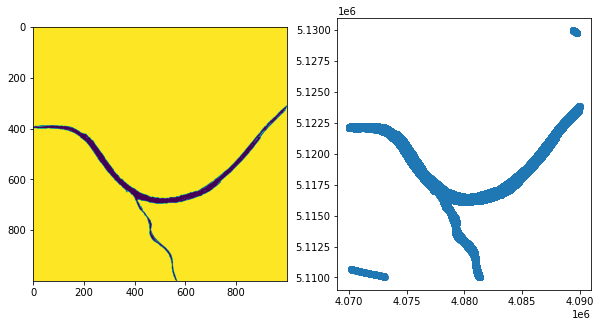

In [5]:
visualize_arr = np.empty([config['NumRow'], config['NumCol']])
clusters = []
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if lattice[i][j]['clusterId']:
            visualize_arr[i][j] = 1
        else:
            visualize_arr[i][j] = 50
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(visualize_arr)
axes[1].scatter(df_processed['x'], df_processed['y'])

## KDE

In [6]:
# start = time.time()
# KDE_object = kde_motion(df_processed, config)
# vessel_pdfs = KDE_object.get_pdfs()
# end = time.time()
# print('Runtime for KDE is: {}'.format(end-start))

## Create Dataset

In [7]:
df_test_original = df_processed.copy()

df_test_original.sort_values(by=['MMSI', 'time'], inplace=True, ascending=True)
df_test_original = df_test_original.reset_index()
df_test_original = df_test_original[['MMSI', 'x', 'y', 'time', 'VesselType', 'Heading']]
df_test_original = df_test_original.groupby('MMSI').filter(lambda x: len(x) > 10000)

shipName = df_test_original['MMSI'].unique()[1]

df_test_original = df_test_original[df_test_original['MMSI'] == shipName]

In [8]:
df_test_original.shape

(107700, 6)

(500, 7)


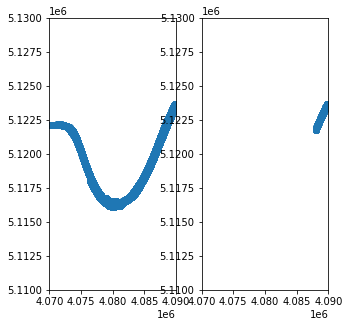

In [9]:
INDEX = 500

df_test = df_test_original[:INDEX]
df_test = df_test.reset_index()

fig, axes = plt.subplots(1,2,figsize=(5,5))
axes[0].scatter(df_test_original['x'], df_test_original['y'])
axes[0].set_xlim(config['FilterMap'][1], config['FilterMap'][0])
axes[0].set_ylim(config['FilterMap'][3], config['FilterMap'][2])
axes[1].scatter(df_test['x'], df_test['y'])
axes[1].set_xlim(config['FilterMap'][1], config['FilterMap'][0])
axes[1].set_ylim(config['FilterMap'][3], config['FilterMap'][2])
print(df_test.shape)

## Long Term Prediction

In [62]:
start = time.time()
# testMotionPrediction = motion_prediction(lattice, vessel_pdfs[str(shipName)], df_test, config)
testMotionPrediction = motion_prediction(lattice, None, df_test, config)
# predicted_PTP_ELR = testMotionPrediction.forecast_all()
# predicted_index = testMotionPrediction.summarize_results()
all_traj = testMotionPrediction.forecast_trajectory()
predicted_index = testMotionPrediction.summarize_traj(all_traj)
predicted_traj = testMotionPrediction.smoothen_traj(predicted_index)
end = time.time()
print('Runtime for one round of motion prediction is: {}'.format(end-start))
# print(predicted_index)

Runtime for one round of motion prediction is: 0.007945060729980469


t: [4087740.         4087740.         4087740.         4087740.
 4087754.         4087758.         4087762.         4087766.
 4087770.         4087773.33333333 4087776.66666667 4087780.
 4087783.33333333 4087786.66666667 4087790.         4087794.
 4087798.         4087802.         4087806.         4087810.
 4087814.         4087818.         4087822.         4087826.
 4087830.         4087833.33333333 4087836.66666667 4087840.
 4087843.33333333 4087846.66666667 4087850.         4087854.
 4087858.         4087862.         4087866.         4087870.
 4087873.33333333 4087876.66666667 4087880.         4087883.33333333
 4087886.66666667 4087890.         4087893.33333333 4087896.66666667
 4087900.         4087901.66666667 4087903.33333333 4087905.
 4087906.66666667 4087908.33333333 4087910.         4087914.
 4087918.         4087922.         4087926.         4087930.
 4087934.         4087938.         4087942.         4087946.
 4087963.72332246 4087963.72332246 4087963.72332246 4087963.723322

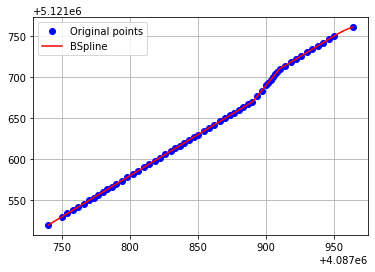

In [63]:
import scipy.interpolate as interpolate

temp = predicted_traj.copy()
temp.sort(key=lambda x: x[0], reverse=False)

x = np.array(temp)[:,0]
y = np.array(temp)[:,1]

t, c, k = interpolate.splrep(x, y, k=3, s=0)
print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x, y, 'bo', label='Original points')
plt.plot(xx, spline(xx), 'r', label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.show()

In [64]:
# predicted_PTP_ELR
# print(testMotionPrediction.initial_ELR)
# predicted_index
# predicted_traj
for i in range(len(predicted_traj)):
    predicted_traj[i] = list(predicted_traj[i])
new = smooth(predicted_traj)
new

[[4087963.723322456, 5121760.714613707],
 [4087950.9723322457, 5121750.671461371],
 [4087946.0972332247, 5121746.067146137],
 [4087942.0097233225, 5121742.006714614],
 [4087938.0009723324, 5121738.000671461],
 [4087934.0000972333, 5121734.0000671465],
 [4087930.0000097235, 5121730.000006715],
 [4087926.0000009723, 5121726.0000006715],
 [4087922.0000000973, 5121722.000000067],
 [4087918.00000001, 5121718.0000000065],
 [4087914.000000001, 5121714.000000001],
 [4087910.2333333334, 5121710.066666666],
 [4087908.356666667, 5121706.673333334],
 [4087906.6689999998, 5121703.334],
 [4087905.0002333336, 5121700.000066667],
 [4087903.333356667, 5121696.666673333],
 [4087901.666669, 5121693.333334],
 [4087899.833333567, 5121689.666666733],
 [4087896.650000023, 5121683.300000006],
 [4087893.331666669, 5121676.663333334],
 [4087889.9998333333, 5121670.333000001],
 [4087886.66665, 5121666.699966667],
 [4087883.333331667, 5121663.336663333],
 [4087879.9999998333, 5121660.000333],
 [4087876.6666666497

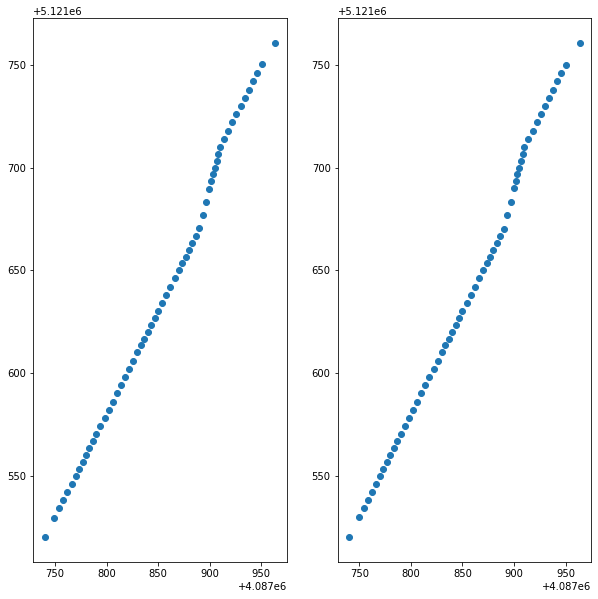

In [65]:
x_old, y_old = [], []
x, y = [], []

for i in range(len(predicted_traj)):
    x_old.append(predicted_traj[i][0])
    y_old.append(predicted_traj[i][1])
for i in range(len(new)):
    x.append(new[i][0])
    y.append(new[i][1])
    
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].scatter(x, y)
axes[1].scatter(x_old, y_old)

## Running tests

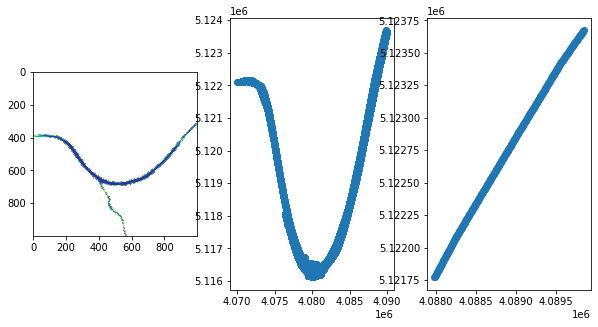

In [14]:
visualize_arr = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if lattice[i][j]['clusterId'] == None:
            visualize_arr[i][j] = 50
        else:
            visualize_arr[i][j] = int(lattice[i][j]['clusterId'])

fig, axes = plt.subplots(1, 3, figsize=(10,5))
axes[0].imshow(visualize_arr, cmap='terrain')
axes[1].scatter(df_test_original['x'], df_test_original['y'])
axes[2].scatter(df_test['x'], df_test['y'])

In [15]:
palette = np.array([[  0,   0,   0],    # Black
                    [255,   0,   0],    # Red
                    [  0, 255,   0],    # Green
                    [  0,   0, 255],    # Blue
                    [255, 255, 255]])   # White

In [16]:
# Cell to find the actual positions in the next time windows
ground_truth = {}
trajectory_gt = []
start_x, start_y = testMotionPrediction.get_index(testMotionPrediction.present_df['x'].iloc[-1], testMotionPrediction.present_df['y'].iloc[-1])
cur_waterway = lattice[start_y][start_x]['clusterId']

cur_x, cur_y, cur_time = df_test['x'].iloc[-1], df_test['y'].iloc[-1], df_test['time'].iloc[-1]
for time_window in config['TimeWindows']:
    next_time = cur_time + time_window
    i = 0
    while True:
        new_time = df_test_original['time'].iloc[INDEX + i]
        if new_time > next_time:
            break
        i += 1
    next_x, next_y, new_time = df_test_original['x'].iloc[INDEX+i], df_test_original['y'].iloc[INDEX+i], df_test_original['time'].iloc[INDEX+i]
    ratio = (next_time - cur_time) / (new_time - cur_time)
    new_x = cur_x + ratio * (next_x - cur_x)
    new_y = cur_y + ratio * (next_y - cur_y)
    trajectory_gt.append((new_x, new_y))
    end_x, end_y = testMotionPrediction.get_index(new_x, new_y)
    ground_truth[time_window] = (end_x, end_y)
ground_truth  # use this line to find zoom

{1: (898, 411),
 2: (898, 411),
 3: (898, 412),
 4: (898, 412),
 5: (898, 412),
 6: (897, 412),
 7: (897, 412),
 8: (897, 413),
 9: (897, 413),
 10: (897, 413),
 11: (896, 413),
 12: (896, 413),
 13: (896, 414),
 14: (896, 414),
 15: (896, 414),
 16: (896, 414),
 17: (895, 414),
 18: (895, 414),
 19: (895, 415),
 20: (895, 415),
 21: (895, 415),
 22: (895, 415),
 23: (894, 415),
 24: (894, 416),
 25: (894, 416),
 26: (894, 416),
 27: (894, 416),
 28: (894, 416),
 29: (893, 417),
 30: (893, 417),
 31: (893, 417),
 32: (893, 417),
 33: (893, 417),
 34: (893, 418),
 35: (892, 418),
 36: (892, 418),
 37: (892, 418),
 38: (892, 418),
 39: (892, 419),
 40: (892, 419),
 41: (891, 419),
 42: (891, 419),
 43: (891, 419),
 44: (891, 420),
 45: (891, 420),
 46: (890, 420),
 47: (890, 420),
 48: (890, 420),
 49: (890, 421),
 50: (890, 421),
 51: (890, 421),
 52: (889, 421),
 53: (889, 421),
 54: (889, 422),
 55: (889, 422),
 56: (889, 422),
 57: (889, 422),
 58: (888, 422),
 59: (888, 423),
 60: (

Text(0, 0.5, 'y')

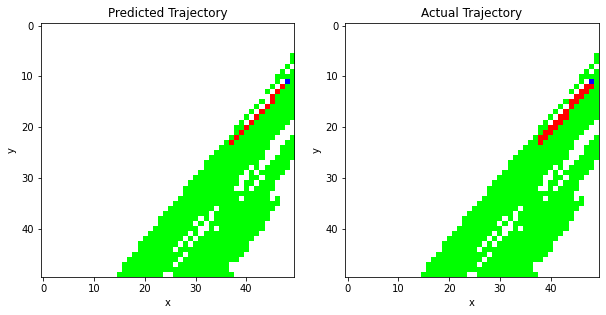

In [18]:
actual_pos = set()
pred_pos = set()
for time_window in config['TimeWindows']:
    pred_pos.add((predicted_index[time_window]))
    actual_pos.add((ground_truth[time_window]))

ZOOM = [850, 900, 400, 450]  # start_x, end_x, start_y, end_y
NUMROW = 50
NUMCOL = 50
visualize_arr_pred = np.empty([ZOOM[3]-ZOOM[2], ZOOM[1]-ZOOM[0]])
for i in range(NUMROW):
    for j in range(NUMCOL):
        if j+ZOOM[0] == start_x and i+ZOOM[2] == start_y:
            visualize_arr_pred[i][j] = 3
        elif (j+ZOOM[0],i+ZOOM[2]) in pred_pos:
            visualize_arr_pred[i][j] = 1
        elif lattice[i+ZOOM[2]][j+ZOOM[0]]['clusterId'] == cur_waterway:
            visualize_arr_pred[i][j] = 2
        else:
            visualize_arr_pred[i][j] = 4
            
visualize_arr_act = np.empty([ZOOM[3]-ZOOM[2], ZOOM[1]-ZOOM[0]])
for i in range(NUMROW):
    for j in range(NUMCOL):
        if j+ZOOM[0] == start_x and i+ZOOM[2] == start_y:
            visualize_arr_act[i][j] = 3
        elif (j+ZOOM[0],i+ZOOM[2]) in actual_pos:
            visualize_arr_act[i][j] = 1
        elif lattice[i+ZOOM[2]][j+ZOOM[0]]['clusterId'] == cur_waterway:
            visualize_arr_act[i][j] = 2
        else:
            visualize_arr_act[i][j] = 4    
            
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(palette[visualize_arr_pred.astype(np.int32)])
axes[0].set_title('Predicted Trajectory')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[1].imshow(palette[visualize_arr_act.astype(np.int32)])
axes[1].set_title('Actual Trajectory')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

In [20]:
# print('Predicted Positions: ', pred_pos)
# print('\n')
# print('Actual Positions:    ', actual_pos)

In [21]:
MSE = 0
for time_window in config['TimeWindows']:
    error = ((predicted_index[time_window][0] - ground_truth[time_window][0]) ** 2 + (predicted_index[time_window][1] - ground_truth[time_window][1]) ** 2) ** 0.5
    MSE += error
print(MSE)
print(MSE/60 * 20)

447.11424918688266
149.03808306229422


In [30]:
total_error = 0
for i in range(len(trajectory_gt)):
    total_error += ((predicted_traj[i][0] - trajectory_gt[i][0]) ** 2 + (predicted_traj[i][1] - trajectory_gt[i][1]) ** 2) ** 0.5
print(total_error / 60)

153.37288093504947


## Visualizing Single time window

Initial Position before prediction is: (817, 513)
Actual Position after time window: (808, 523)
Predicted Position after time window: (807, 523)
Actual Distance between points is: 264.8718323982415


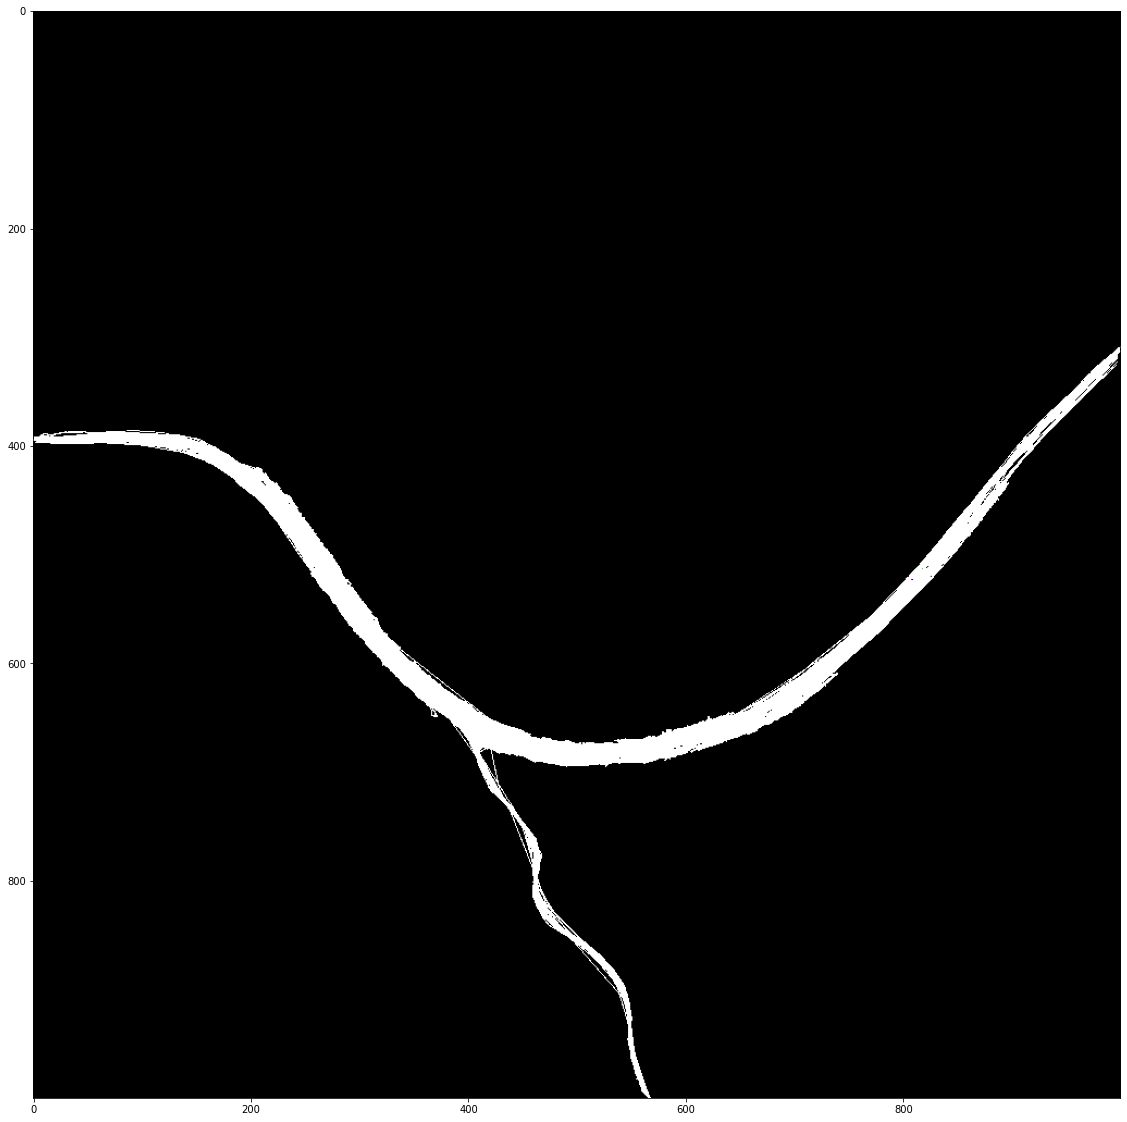

In [53]:
time_window = config['TimeWindows'][50]

# Get initial and final positions
start_x, start_y = testMotionPrediction.get_index(testMotionPrediction.present_df['x'].iloc[-1], testMotionPrediction.present_df['y'].iloc[-1])
cur_x, cur_y, cur_time = df_test['x'].iloc[-1], df_test['y'].iloc[-1], df_test['time'].iloc[-1]
next_time = cur_time + time_window
i = 0
while True:
    new_time = df_test_original['time'].iloc[INDEX+i]
    if new_time > next_time:
        break
    i += 1

next_x, next_y, new_time = df_test_original['x'].iloc[INDEX+i], df_test_original['y'].iloc[INDEX+i], df_test_original['time'].iloc[INDEX+i]
ratio = (next_time - cur_time) / (new_time - cur_time)
new_x = cur_x + ratio * (next_x - cur_x)
new_y = cur_y + ratio * (next_y - cur_y)
end_x, end_y = testMotionPrediction.get_index(new_x, new_y)

actual_dist = ((new_x - cur_x) ** 2 + (new_y - cur_y) ** 2) ** 0.5

print('Initial Position before prediction is: {}'.format((start_x, start_y)))
print('Actual Position after time window: {}'.format((end_x, end_y)))
print('Predicted Position after time window: {}'.format(predicted_index[time_window]))
print('Actual Distance between points is: {}'.format(actual_dist))

cur_waterway = lattice[start_y][start_x]['clusterId']

visualize_arr = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if j == start_x and i == start_y:
            visualize_arr[i][j] = 2
        elif j == end_x and i == end_y:
            visualize_arr[i][j] = 3
        elif j == int(predicted_index[time_window][0]) and i == int(predicted_index[time_window][1]):
            visualize_arr[i][j] = 1
        elif lattice[i][j]['clusterId'] == cur_waterway:
            visualize_arr[i][j] = 4
        else:
            visualize_arr[i][j] = 0

fig, axes = plt.subplots(1,1,figsize=(20,20))
axes.imshow(palette[visualize_arr.astype(np.int32)])
# palette[visualize_arr]
# visualize_arr.astype(np.int32)

## TESTING OF CUSTOM DATASET

In [205]:
# import unittest

# def get_index(pos_x, pos_y, min_x, min_y, increment, numRow):
#     index_x = math.ceil((pos_x - min_x) / increment) - 1
#     index_y = numRow - math.ceil((pos_y - min_y) / increment)
#     if pos_y == min_y:
#         index_y = numRow-1
#     if pos_x == min_x:
#         index_x = 0
#     return (index_x, index_y)

# class MotionPredictionTestCase(unittest.TestCase):
#     def setUp(self):
#         self.config = {'EarthRadius': 6371000,
#                        'ScaleDown': 10**3,
#                        'VesselType': None,
#                        'FilterMap': FilterMap,
#                        'NumCol': 100,
#                        'NumRow': 100,
#                        'Increment': 1,
#                        'Min_x': 0,
#                        'Min_y': 0,
#                        'MinSC': 2,
#                        'MinNeigb': 2,
#                        'StoreParam': [-4, 4, 101],
#                        'TimeWindows': [i for i in range(1, 61)],
#                        'Threshold': None,
#                       }
        
#         lattice_clusters = pd.read_csv('./sample_lattice.csv').to_numpy()
#         lattice = [[None] * self.config['NumCol'] for _ in range(self.config['NumRow'])]
#         for i in range(self.config['NumRow']):
#             for j in range(self.config['NumCol']):
#                 lattice[self.config['NumRow']-1-i][j] = {'x': self.config['Min_x'] + j * self.config['Increment'], 
#                                                          'y': self.config['Min_y'] + i * self.config['Increment'], 
#                                                          'code':None, 
#                                                          'sampleCount': 0, 
#                                                          'type/vslid': self.config['VesselType'], 
#                                                          'label': None, 
#                                                          'clusterId': None}
#         for i in range(self.config['NumRow']):
#             for j in range(self.config['NumCol']):
#                 if i < lattice_clusters.shape[0] and j < lattice_clusters.shape[1] and lattice_clusters[i][j] == 1.:
#                     lattice[i][j]['clusterId'] = 1
#         self.lattice = lattice
        
#         self.df_test = df.DataFrame({'MMSI': [1 for _ in range(21)],
#                                      'x': [100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80],
#                                      'y': [100, 99, 98, 96, 94, 92, 90, 89, 88, 87, 86, 85, 84, 83, 83, 82, 81, 80, 79, 79, 78],
#                                      'time': [5 * i for i in range(21)],  # 0 - 100 seconds
#                                      'VesselType': [1 for _ in range(21)],
#                                      'Heading': [225 for _ in range(21)],
#                                     })

In [190]:
config = {'EarthRadius': 6371000,
           'ScaleDown': 10**3,
           'VesselType': None,
           'FilterMap': FilterMap,
           'NumCol': 100,
           'NumRow': 100,
           'Increment': 1,
           'Min_x': 0,
           'Min_y': 0,
           'MinSC': 2,
           'MinNeigb': 2,
           'StoreParam': [-4, 4, 101],
           'TimeWindows': [i for i in range(1, 61)],
           'Threshold': None,
          }
        
lattice_clusters = pd.read_csv('./sample_lattice.csv').to_numpy()
customLattice = [[None] * config['NumCol'] for _ in range(config['NumRow'])]
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        customLattice[config['NumRow']-1-i][j] = {'x': config['Min_x'] + j * config['Increment'], 
                                                  'y': config['Min_y'] + i * config['Increment'], 
                                                  'code':None, 
                                                  'sampleCount': 0, 
                                                  'type/vslid': config['VesselType'], 
                                                  'label': None, 
                                                  'clusterId': None}
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if i < lattice_clusters.shape[0] and j < lattice_clusters.shape[1] and lattice_clusters[i][j] == 1.:
            customLattice[i][j]['clusterId'] = 1

x_locs = [100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80]
y_locs = [100, 99, 98, 96, 94, 92, 90, 89, 88, 87, 86, 85, 84, 83, 83, 82, 81, 80, 79, 79, 78]
# x_locs = [53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33]
# y_locs = [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 50, 49, 48, 47, 46, 44, 42, 40, 43]
df_custom = pd.DataFrame({'MMSI': [1 for _ in range(21)],
                          'x': x_locs,
                          'y': y_locs,
                          'time': [5 * i for i in range(21)],  # 0 - 100 seconds
                          'VesselType': [1 for _ in range(21)],
                          'Heading': [225 for _ in range(21)],
                          })
custom_test_motion_prediction = motion_prediction(customLattice, None, df_custom, config)
pred_PTP_ELR = custom_test_motion_prediction.forecast_trajectory()
pred_index = custom_test_motion_prediction.summarize_traj(pred_PTP_ELR)

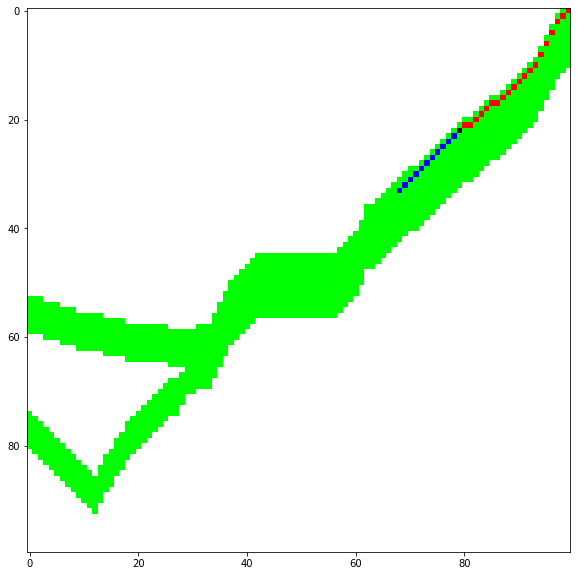

In [208]:
palette = np.array([[  0,   0,   0],    # Black
                    [255,   0,   0],    # Red
                    [  0, 255,   0],    # Green
                    [  0,   0, 255],    # Blue
                    [255, 255, 255]])   # White

actual_pos = set()
pred_pos = set()
historic_pos = set()

# Get the initial positions
start_x, start_y = custom_test_motion_prediction.get_index(custom_test_motion_prediction.present_df['x'].iloc[-1], custom_test_motion_prediction.present_df['y'].iloc[-1])

# Get the predicted positions
for time_window in config['TimeWindows']:
    pred_pos.add((pred_index[time_window]))

# Get historic posisions
for idx, row in df_custom.iterrows():
    x, y = row['x'], row['y']
    index_x, index_y = custom_test_motion_prediction.get_index(x, y)
    historic_pos.add((index_x, index_y))
    
# visualize
cur_waterway = customLattice[start_y][start_x]['clusterId']
visualize_pred_custom = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if j == start_x and i == start_y:
            visualize_pred_custom[i][j] = 0
        elif (j,i) in pred_pos:
            visualize_pred_custom[i][j] = 3
        elif (j,i) in historic_pos:
            visualize_pred_custom[i][j] = 1
        elif customLattice[i][j]['clusterId'] == cur_waterway:
            visualize_pred_custom[i][j] = 2
        else:
            visualize_pred_custom[i][j] = 4

fig, axes = plt.subplots(1, 1, figsize=(10,10))
axes.imshow(palette[visualize_pred_custom.astype(np.int32)])

## Checking error over time

In [9]:
df_test_original.shape

(107700, 6)

In [9]:
def get_ground_truth(motionPrediction, lattice, df, df_original, index, config):
    ground_truth = {}
    traj_gt = {}
    cur_x, cur_y, cur_time = df['x'].iloc[-1], df['y'].iloc[-1], df['time'].iloc[-1]
    for time_window in config['TimeWindows']:
        next_time = cur_time + time_window
        i=0
        while True:
            new_time = df_original['time'].iloc[index + i]
            if new_time > next_time:
                break
            i += 1
        next_x, next_y, new_time = df_original['x'].iloc[index+i], df_original['y'].iloc[index+i], df_original['time'].iloc[index+i]
        ratio = (next_time - cur_time) / (new_time - cur_time)
        new_x = cur_x + ratio * (next_x - cur_x)
        new_y = cur_y + ratio * (next_y - cur_y)
        end_x, end_y = motionPrediction.get_index(new_x, new_y)
        ground_truth[time_window] = (end_x, end_y)
        traj_gt[time_window] = (new_x, new_y)
    return ground_truth, traj_gt

In [70]:
time_taken = []
average_errors = []
average_dist_errors = []
numLargeErrors = []
emptyResIndex = []
error_threshold = 2 ** 0.5
for index in range(100, df_test_original.shape[0]-60, 5):
    if index % 10000 == 0:
        print(index)
    # Create Dataset
    temp_test_df = df_test_original[:index]
    temp_test_df = temp_test_df.reset_index()
    
    # Make predicitons
    start = time.time()
    motionPrediction = motion_prediction(lattice, None, temp_test_df, config)
#     _ = motionPrediction.forecast_all()
#     pred_index = motionPrediction.summarize_results()
    pred_index = motionPrediction.summarize_traj(motionPrediction.forecast_trajectory())
    pred_traj = motionPrediction.smoothen_traj(pred_index)
    end = time.time()
    
    if not pred_index:
        time_taken.append(end-start)
        average_errors.append(None)
        average_dist_errors.append(None)
        numLargeErrors.append(None)
        emptyResIndex.append(index)
        continue
    
    # Get ground truths
    ground_truth, traj_gt = get_ground_truth(motionPrediction, lattice, temp_test_df, df_test_original, index, config)
    
    # Collect errors
    total_error = 0
    total_dist_error = 0
    largeErr = 0

    for time_window in config['TimeWindows']:
        error = ((pred_index[time_window][0] - ground_truth[time_window][0])**2 + (pred_index[time_window][1] - ground_truth[time_window][1])**2) ** 0.5
        dist_error = ((pred_traj[time_window-1][0] - traj_gt[time_window][0])**2 + (pred_traj[time_window-1][1] - traj_gt[time_window][1])**2) ** 0.5
        total_error += error
        total_dist_error += dist_error
        if error > error_threshold:
            largeErr += 1
    
    # Records
    time_taken.append(end-start)
    average_errors.append(total_error/len(config['TimeWindows']))
    average_dist_errors.append(total_dist_error/len(config['TimeWindows']))
    numLargeErrors.append(largeErr)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [71]:
# Metrics

max_error = 0
max_error_index = 0
total_error = 0

max_dist_error = 0
max_dist_error_index = 0
total_dist_error = 0

count = 0
num_nones = 0
none_index = []
acceptableThreshold = 2
acceptable = 0
notAcceptable = 0
index_list = []



for idx, error in enumerate(average_errors):
    if error == None:
        num_nones += 1
        none_index.append(idx)
        continue
    if max_error < error:
        max_error = error
        max_error_index = idx
    if error > acceptableThreshold:
        notAcceptable += 1
    if error > 5:
        index_list.append(idx)
    else:
        acceptable += 1
    total_error += error
    count += 1

for idx, dist_error in enumerate(average_dist_errors):
    if dist_error == None:
        continue
    if max_dist_error < dist_error:
        max_dist_error = dist_error
        max_dist_error_index = idx
    total_dist_error += dist_error
    
print('The maximum error is:\t', max_error)
print('The maximum error index is:\t', max_error_index)
print('Average of all errors:\t', total_error/count)
print('Number acceptable errors:\t', acceptable)
print('Number not acceptable errors:\t', notAcceptable)
print('Number of nones:\t', num_nones)
print('\n')
print('The maximum distance error is:\t', max_dist_error)
print('The maximum distance error index is:\t', max_dist_error_index)
print('Average of all distance errors:\t', total_dist_error/count)

The maximum error is:	 7.451904153114711
The maximum error index is:	 4736
Average of all errors:	 0.4810305073350519
Number acceptable errors:	 21486
Number not acceptable errors:	 748
Number of nones:	 5


The maximum distance error is:	 156.74689707788195
The maximum distance error index is:	 4736
Average of all distance errors:	 10.885659882677132


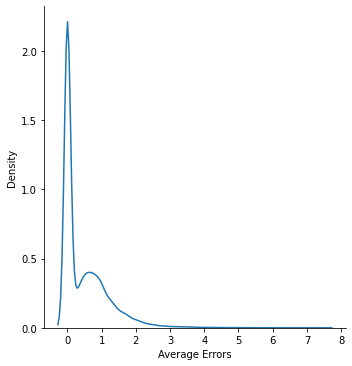

In [112]:
import seaborn as sb
temp = []
for error in average_errors:
    if error != None:
        temp.append(error)
ax = sb.displot(np.array(temp), kind='kde')
ax.set(xlabel='Average Errors')
plt.show()

In [22]:
index_list

[2425,
 4646,
 4732,
 4733,
 4734,
 4735,
 4736,
 4741,
 4742,
 11251,
 12233,
 12234,
 15764,
 15765,
 15766,
 17359,
 17360]

In [10]:
testing_all_ships_df = df_processed.copy()
testing_all_ships_df.sort_values(by=['MMSI', 'time'], inplace=True, ascending=True)
testing_all_ships_df = testing_all_ships_df.reset_index()
testing_all_ships_df = testing_all_ships_df.groupby('MMSI').filter(lambda x: len(x) > 10000)

time_taken_total = {}
average_errors_total = {}
average_dist_errors_total = {}
numLargeErrors_total = {}
emptyResIndex_total = {}
error_threshold = 2 ** 0.5

for shipName in testing_all_ships_df['MMSI'].unique():
    testing_df = testing_all_ships_df[testing_all_ships_df['MMSI'] == shipName]
    
    time_taken = []
    average_errors = []
    average_dist_errors = []
    numLargeErrors = []
    emptyResIndex = []

    for index in range(100, testing_df.shape[0]-60, 5):
        if index % 10000 == 0:
            print('{}: {}'.format(shipName, index))
        temp_testing_df = testing_df[:index]
        temp_testing_df = temp_testing_df.reset_index()
        
        start = time.time()
        motionPrediction = motion_prediction(lattice, None, temp_testing_df, config)
        pred_index = motionPrediction.summarize_traj(motionPrediction.forecast_trajectory())
        pred_traj = motionPrediction.smoothen_traj(pred_index)
        end = time.time()
        
        if not pred_index:
            time_taken.append(end-start)
            average_errors.append(None)
            average_dist_errors.append(None)
            numLargeErrors.append(None)
            emptyResIndex.append(index)
            continue
        
        ground_truth, traj_gt = get_ground_truth(motionPrediction, lattice, temp_testing_df, testing_df, index, config)
        
        total_error = 0
        total_dist_error = 0
        largeErr = 0
        
        for time_window in config['TimeWindows']:
            error = ((pred_index[time_window][0] - ground_truth[time_window][0])**2 + (pred_index[time_window][1] - ground_truth[time_window][1])**2) ** 0.5
            dist_error = ((pred_traj[time_window-1][0] - traj_gt[time_window][0])**2 + (pred_traj[time_window-1][1] - traj_gt[time_window][1])**2) ** 0.5
            total_error += error
            total_dist_error += dist_error
            if error > error_threshold:
                largeErr += 1
        
        time_taken.append(end-start)
        average_errors.append(total_error/len(config['TimeWindows']))
        average_dist_errors.append(total_dist_error/len(config['TimeWindows']))
        numLargeErrors.append(largeErr)
    
    time_taken_total[shipName] = time_taken
    average_errors_total[shipName] = average_errors
    average_dist_errors_total[shipName] = average_dist_errors
    numLargeErrors_total[shipName] = numLargeErrors
    emptyResIndex_total[shipName] = emptyResIndex

366856070.0: 10000
366856070.0: 20000
366856070.0: 30000
366856070.0: 40000
366856070.0: 50000
366856070.0: 60000
366856070.0: 70000
366856070.0: 80000
366856070.0: 90000
366856070.0: 100000
366856070.0: 110000
366856070.0: 120000
366856070.0: 130000
366856070.0: 140000
366856070.0: 150000
366856070.0: 160000
366856070.0: 170000
366856070.0: 180000
366856070.0: 190000
366856070.0: 200000
366856070.0: 210000
366856070.0: 220000
366856070.0: 230000
366856070.0: 240000
366856070.0: 250000
366856070.0: 260000
366856070.0: 270000
366856070.0: 280000
366856070.0: 290000
366856070.0: 300000
366856070.0: 310000
366856070.0: 320000
366856070.0: 330000
366856070.0: 340000
366856070.0: 350000
366856460.0: 10000
366856460.0: 20000
366856460.0: 30000
366856460.0: 40000
366856460.0: 50000
366856460.0: 60000
366856460.0: 70000
366856460.0: 80000
366856460.0: 90000
366856460.0: 100000
366862820.0: 10000
366862820.0: 20000
366862820.0: 30000
366862820.0: 40000
366862820.0: 50000
366862820.0: 60000
3669

KeyboardInterrupt: 

In [38]:
new = set()
new.add((2,3))